In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.statespace.sarimax import SARIMAX
import pmdarima as pm

In [5]:
# ===========================
# 2. READ CSV & PARSE DATE
# ===========================
file_path = r"Daily_Public_Transport_Passenger_Journeys_by_Service_Type_20250603.csv"

df = pd.read_csv(file_path)

# Parse date column (change "Date" if your column name differs)
df["Date"] = pd.to_datetime(df["Date"])

# Set datetime index and sort
df = df.set_index("Date").sort_index()

print("After reading:")
print(df.head())
print(df.info())


After reading:
            Local Route  Light Rail  Peak Service  Rapid Route  School  Other
Date                                                                         
2019-07-01        15987        9962           407        21223    3715    NaN
2019-07-02        16895       10656           409        21715    3993    NaN
2019-07-03        16613       10658           427        22025    3638    NaN
2019-07-04        16604       10445           437        21868    3576    NaN
2019-07-05        16040       10532           400        20697    2856    NaN
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1918 entries, 2019-07-01 to 2024-09-29
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Local Route   1918 non-null   int64  
 1   Light Rail    1918 non-null   int64  
 2   Peak Service  1918 non-null   int64  
 3   Rapid Route   1918 non-null   int64  
 4   School        1918 non-null   int64  
 5   Other    

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_15196\2875306095.py:9: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df["Date"] = pd.to_datetime(df["Date"])


In [6]:
# ===========================
# 4. ENSURE DAILY FREQUENCY & HANDLE MISSING VALUES
# ===========================
# Force daily frequency (creates rows for missing dates)
df = df.asfreq("D")

# Interpolate by time, then fill any remaining edges
df = df.interpolate(method="time").ffill().bfill()

print("\nMissing values after cleaning:")
print(df.isna().sum())



Missing values after cleaning:
Local Route     0
Light Rail      0
Peak Service    0
Rapid Route     0
School          0
Other           0
dtype: int64


In [7]:
#stationary check:
from statsmodels.tsa.stattools import adfuller

print("ADF TEST RESULTS\n")

for col in df.columns:
    try:
        series = df[col].dropna()

        # skip non-numeric columns
        if not pd.api.types.is_numeric_dtype(series):
            print(f"{col} -> Skipped (Not numeric)")
            continue

        result = adfuller(series)

        p_value = result[1]

        if p_value < 0.05:
            print(f"{col} -> ✅ Stationary (p = {p_value:.4f})")
        else:
            print(f"{col} -> ❌ Non-stationary (p = {p_value:.4f})")

    except Exception as e:
        print(f"{col} -> Error: {str(e)}")


ADF TEST RESULTS

Local Route -> ✅ Stationary (p = 0.0001)
Light Rail -> ✅ Stationary (p = 0.0081)
Peak Service -> ✅ Stationary (p = 0.0023)
Rapid Route -> ✅ Stationary (p = 0.0026)
School -> ✅ Stationary (p = 0.0000)
Other -> ✅ Stationary (p = 0.0067)


In [8]:
# ===========================
# 5. CREATE TOTAL RIDERSHIP SERIES
# ===========================
# Sum across all service columns to get total ridership per day
df["Total"] = df.sum(axis=1)

ts = df["Total"].asfreq("D")

print("\nTotal series preview:")
print(ts.head())



Total series preview:
Date
2019-07-01    51294.0
2019-07-02    53668.0
2019-07-03    53361.0
2019-07-04    52930.0
2019-07-05    50525.0
Freq: D, Name: Total, dtype: float64


In [29]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

def evaluate(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    
    # safe MAPE (avoids divide-by-zero explosion)
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mask = y_true != 0
    mape = np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100
    
    return mae, rmse, mape



-----------------------------------------
SERVICE: Local Route
-----------------------------------------
BEST ORDER: (1, 1, 1)
BEST SEASONAL ORDER: (1, 1, 1, 7)
MAE = 2359.24, RMSE = 4370.54, MAPE = 15531.08


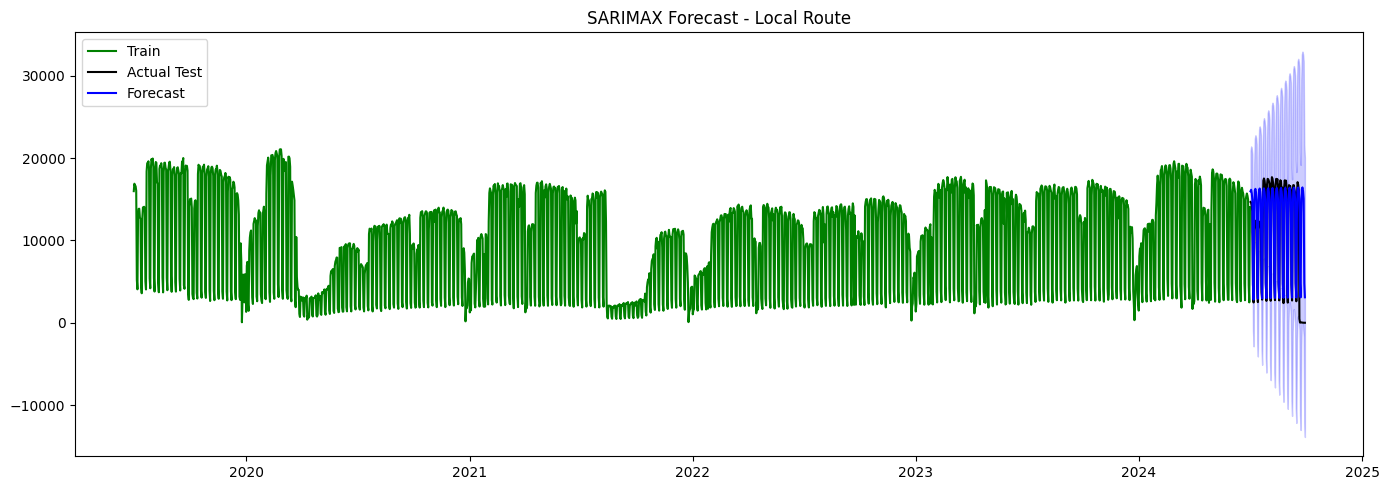


Next 7 days forecast:
2024-07-02    15975.85
2024-07-03    16154.34
2024-07-04    15750.15
2024-07-05    14934.24
2024-07-06     4623.30
2024-07-07     2814.86
2024-07-08    13437.15
Freq: D, Name: predicted_mean, dtype: float64

-----------------------------------------
SERVICE: Light Rail
-----------------------------------------
BEST ORDER: (1, 1, 1)
BEST SEASONAL ORDER: (1, 1, 1, 7)
MAE = 1444.82, RMSE = 2670.02, MAPE = 184.39


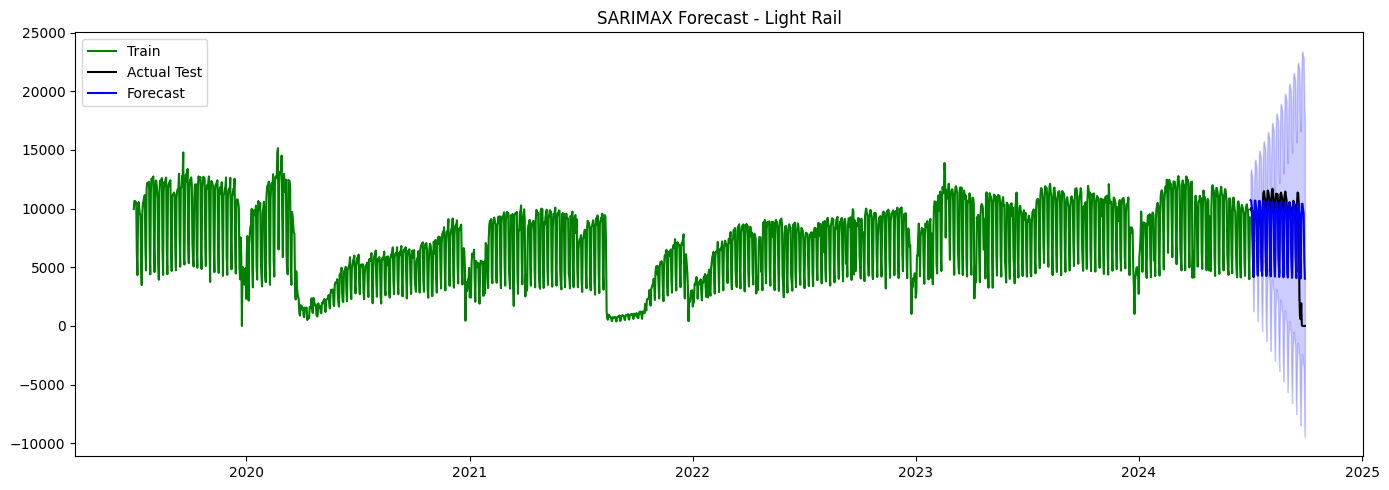


Next 7 days forecast:
2024-07-02    10720.97
2024-07-03    10682.42
2024-07-04    10183.96
2024-07-05     9891.58
2024-07-06     5932.76
2024-07-07     4275.43
2024-07-08     8785.53
Freq: D, Name: predicted_mean, dtype: float64

-----------------------------------------
SERVICE: Peak Service
-----------------------------------------
BEST ORDER: (1, 1, 1)
BEST SEASONAL ORDER: (1, 1, 1, 7)
MAE = 35.09, RMSE = 82.55, MAPE = 627.58


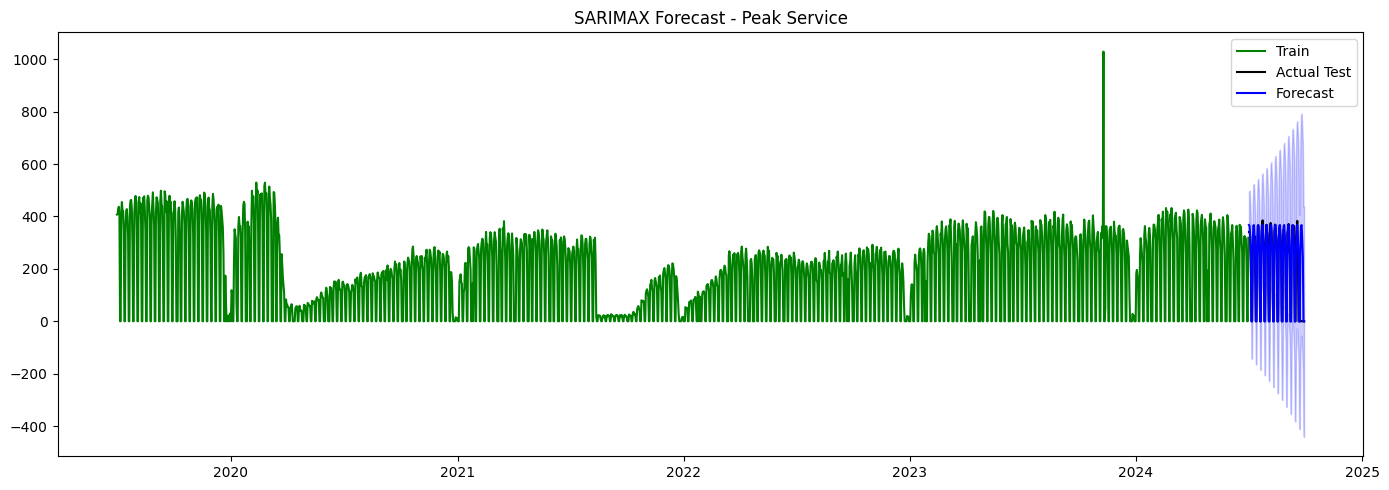


Next 7 days forecast:
2024-07-02    367.35
2024-07-03    362.95
2024-07-04    313.82
2024-07-05    243.04
2024-07-06      0.00
2024-07-07      0.00
2024-07-08    287.18
Freq: D, Name: predicted_mean, dtype: float64

-----------------------------------------
SERVICE: Rapid Route
-----------------------------------------
BEST ORDER: (1, 1, 1)
BEST SEASONAL ORDER: (1, 1, 1, 7)
MAE = 2687.32, RMSE = 5186.69, MAPE = 10236.77


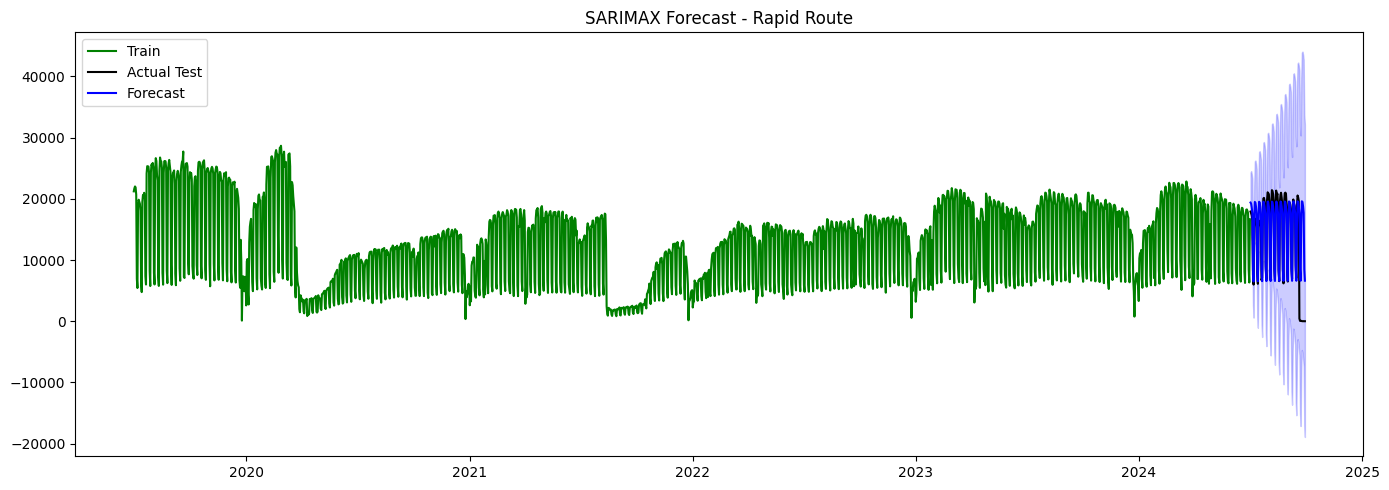


Next 7 days forecast:
2024-07-02    19394.24
2024-07-03    19202.86
2024-07-04    18558.05
2024-07-05    17630.72
2024-07-06     8397.99
2024-07-07     6496.22
2024-07-08    15933.76
Freq: D, Name: predicted_mean, dtype: float64

-----------------------------------------
SERVICE: School
-----------------------------------------
BEST ORDER: (1, 1, 1)
BEST SEASONAL ORDER: (1, 1, 1, 7)
MAE = 1369.42, RMSE = 1791.66, MAPE = 7983.73


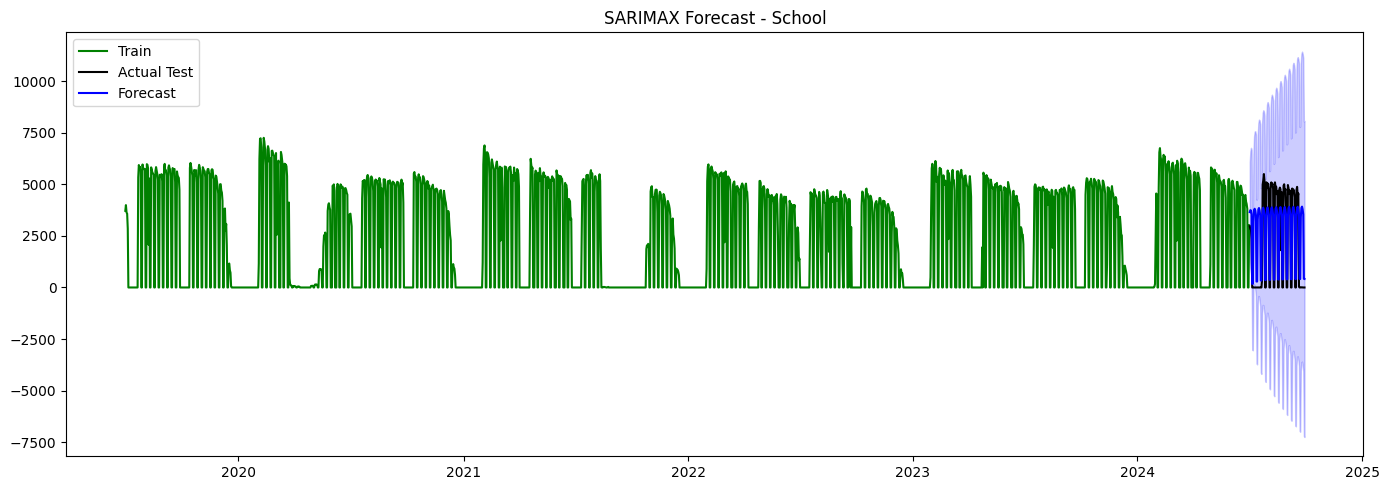


Next 7 days forecast:
2024-07-02    3654.72
2024-07-03    3749.78
2024-07-04    3731.85
2024-07-05    3552.38
2024-07-06     171.02
2024-07-07     184.77
2024-07-08    3202.42
Freq: D, Name: predicted_mean, dtype: float64

-----------------------------------------
SERVICE: Other
-----------------------------------------
BEST ORDER: (1, 0, 1)
BEST SEASONAL ORDER: (0, 1, 1, 7)
MAE = 14.34, RMSE = 23.33, MAPE = 16.73


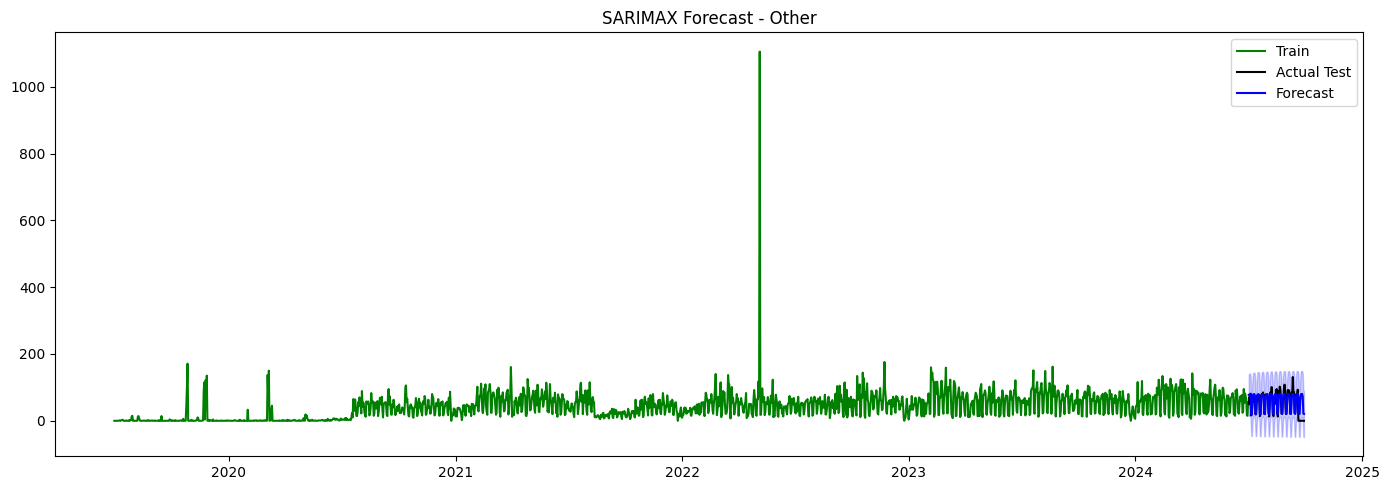


Next 7 days forecast:
2024-07-02    77.62
2024-07-03    77.45
2024-07-04    78.74
2024-07-05    71.16
2024-07-06    19.70
2024-07-07    18.83
2024-07-08    57.76
Freq: D, Name: predicted_mean, dtype: float64


In [30]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import itertools

results_summary = []

for target_service in services:
    print("\n-----------------------------------------")
    print(f"SERVICE: {target_service}")
    print("-----------------------------------------")

    ts = df[target_service].dropna()

    # train-test split
    test_days = 90
    train = ts.iloc[:-test_days]
    test = ts.iloc[-test_days:]

    # SARIMA order search
    p = d = q = [0,1]
    P = D = Q = [0,1]
    seasonal_period = 7

    best_aic = np.inf
    best_order = None
    best_seasonal = None

    for order in itertools.product(p, d, q):
        for seasonal in itertools.product(P, D, Q):
            seasonal_order = (seasonal[0], seasonal[1], seasonal[2], seasonal_period)
            try:
                model = SARIMAX(train,
                                order=order,
                                seasonal_order=seasonal_order,
                                enforce_stationarity=False,
                                enforce_invertibility=False)
                res = model.fit(disp=False)

                if res.aic < best_aic:
                    best_aic = res.aic
                    best_order = order
                    best_seasonal = seasonal_order

            except:
                continue

    print(f"BEST ORDER: {best_order}")
    print(f"BEST SEASONAL ORDER: {best_seasonal}")

    # fit final model
    model = SARIMAX(train,
                    order=best_order,
                    seasonal_order=best_seasonal,
                    enforce_stationarity=False,
                    enforce_invertibility=False)

    result = model.fit(disp=False)

    # forecast last test_days (test set)
    forecast = result.get_forecast(steps=test_days)
    forecast_values = forecast.predicted_mean
    ci = forecast.conf_int()

    # evaluate
    mae, rmse, mape = evaluate(test, forecast_values)
    print(f"MAE = {round(mae,2)}, RMSE = {round(rmse,2)}, MAPE = {round(mape,2)}")

    # save results
    results_summary.append({
        "service": target_service,
        "order": best_order,
        "seasonal_order": best_seasonal,
        "MAE": mae,
        "RMSE": rmse,
        "MAPE": mape
    })

    # plot
    plt.figure(figsize=(14,5))
    plt.plot(train.index, train, label='Train', color='green')
    plt.plot(test.index, test, label='Actual Test', color='black')
    plt.plot(forecast_values.index, forecast_values, label='Forecast', color='blue')
    plt.fill_between(ci.index, ci.iloc[:,0], ci.iloc[:,1], color='blue', alpha=0.2)
    plt.title(f"SARIMAX Forecast - {target_service}")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # ======================
    # NEXT 7 DAYS FORECAST
    # ======================

    future_steps = 7
    future = result.get_forecast(steps=future_steps)
    future_pred = future.predicted_mean

    # clip negatives
    future_pred[future_pred < 0] = 0

    print("\nNext 7 days forecast:")
    print(future_pred.round(2))   # keeps decimal values


In [31]:
summary_df = pd.DataFrame(results_summary)
summary_df

,service,order,seasonal_order,MAE,RMSE,MAPE
0,Local Route,"(1, 1, 1)","(1, 1, 1, 7)",2359.235248,4370.540315,15531.084869
1,Light Rail,"(1, 1, 1)","(1, 1, 1, 7)",1444.821421,2670.020901,184.392490
2,Peak Service,"(1, 1, 1)","(1, 1, 1, 7)",35.086229,82.547125,627.576250
3,Rapid Route,"(1, 1, 1)","(1, 1, 1, 7)",2687.321659,5186.687583,10236.769477
4,School,"(1, 1, 1)","(1, 1, 1, 7)",1369.416829,1791.656760,7983.727128
5,Other,"(1, 0, 1)","(0, 1, 1, 7)",14.343422,23.333049,16.728194
